In [1]:
from pathways.scenarios import run_scenarios, load_scenario_table
from pathways.simulation import load_configuration
from pathways.outputs import save_scenario_result_to_pandas

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from pathlib import Path
datadir = Path("tests/test_summaries")
basic_config = load_configuration(datadir / "config.yml")

# Load csv with configurations for each validation scenario
scenario_table = load_scenario_table(datadir / "validation_scenarios.csv")

In [4]:
# Separate the scenarios by validation category (contamination, sampling, and outcomes)
contaminate_validation_scenarios = scenario_table[0:16]
sample_validation_scenarios = scenario_table[16:40]
outcome_validation_scenarios = scenario_table[40:80]

# Contamination validation

### Test 1: Simulate 10 consignments with 10 boxes each (200 items/box).
Check contamination rates and contaminant arrangement using combinations of:
* Fixed contamination rates - fixed values of 0.01, 0.1, 0.2
* Contamination unit - box or item
* Contaminant arrangement - random or clustered (box contamination unit: 2 boxes max contaminated units, item contamination unit: 200 items max contaminated units and 400 items max width)

### Test 2: Simulate 1000 consignments with 100 boxes each (200 items/box), repeat for 20 iterations.
Check contamination rates using combinations of::
* Stochastic contamination rates - beta probability distribution using parameters [0.0194628, 2.7609372] (mean = 0.007, sd = 0.05)
* Contamination unit - box or item
* Pest arrangement - random or clustered (box contamination unit: 2 boxes max contaminated units, item contamination unit: 400 items max contaminated units and 400 items max width)

In [5]:
# Run infestation validation test 1
num_consignments_1 = 3
contaminate_validation_1 = run_scenarios(
    config=basic_config,
    scenario_table=contaminate_validation_scenarios[0:12],
    seed=42,
    num_simulations=1,
    num_consignments=num_consignments_1,
    detailed=True,
)

Running scenario: contaminate validation 1
Running scenario: contaminate validation 2
Running scenario: contaminate validation 3
Running scenario: contaminate validation 4
Running scenario: contaminate validation 5
Running scenario: contaminate validation 6
Running scenario: contaminate validation 7
Running scenario: contaminate validation 8
Running scenario: contaminate validation 9
Running scenario: contaminate validation 10
Running scenario: contaminate validation 11
Running scenario: contaminate validation 12


In [6]:
# Run contamination validation test 2
num_consignments_2 = 1000
contaminate_validation_2 = run_scenarios(
    config=basic_config,
    scenario_table=contaminate_validation_scenarios[12:16],
    seed=42,
    num_simulations=20,
    num_consignments=num_consignments_2,
    detailed=False,
)

Running scenario: contaminate validation 13
Running scenario: contaminate validation 14
Running scenario: contaminate validation 15
Running scenario: contaminate validation 16


In [7]:
# Separate item and inspection details from simulation totals and scenario config.
contaminate_validation_details_1 = [i[0] for i in contaminate_validation_1]
contaminate_validation_results_1 = [i[1:3] for i in contaminate_validation_1]

In [8]:
# Save dataframe from simulation totals and scenario config test 1.
contaminate_validation_df_1 = save_scenario_result_to_pandas(
    contaminate_validation_results_1,
    config_columns=[
        "consignment name",
        "consignment/boxes/min",
        "consignment/boxes/max",
        "consignment/items_per_box/default",
        "contamination/contamination_unit",
        "contamination/contamination_rate/distribution",
        "contamination/contamination_rate/value",
        "contamination/contamination_rate/parameters",
        "contamination/arrangement",
        "contamination/clustered/distribution",
        "contamination/clustered/max_contaminated_units_per_cluster",
        "contamination/clustered/random/max_cluster_item_width",
    ],
    result_columns=[
        "true_contamination_rate",
    ],
)

In [9]:
# Save dataframe from simulation totals and scenario config test 2.
contaminate_validation_df_2 = save_scenario_result_to_pandas(
    contaminate_validation_2,
    config_columns=[
        "consignment name",
        "consignment/boxes/min",
        "consignment/boxes/max",
        "consignment/items_per_box/default",
        "contamination/contamination_unit",
        "contamination/contamination_rate/distribution",
        "contamination/contamination_rate/value",
        "contamination/contamination_rate/parameters",
        "contamination/arrangement",
        "contamination/clustered/distribution",
        "contamination/clustered/max_contaminated_units_per_cluster",
        "contamination/clustered/random/max_cluster_item_width",
    ],
    result_columns=[
        "true_contamination_rate",
    ],
)

In [10]:
# Combine dataframes from both tests to view contamination rates
contaminate_validation_df = contaminate_validation_df_1.append(contaminate_validation_df_2)
contaminate_validation_df.index = range(len(contaminate_validation_df))

In [11]:
# Format dataframe
column_names = ["consignment name", "number of boxes", "items per box", "contamination unit", "contamination distribution", "contamination value", "contaminant arrangement", "actual contamination rate (mean)"]
contaminate_validation_df_pretty = contaminate_validation_df.iloc[:,[0,1,3,4,5,6,8,12]]
contaminate_validation_df_pretty.iloc[:,5] = contaminate_validation_df_pretty.iloc[:,5].astype(str)

beta_parameters = contaminate_validation_df.iloc[12:16,7]
contaminate_validation_df_pretty.iloc[12:16,5] = beta_parameters
contaminate_validation_df_pretty.columns = column_names
contaminate_validation_df_pretty.iloc[:,7] = contaminate_validation_df_pretty.iloc[:,7].round(decimals=4)
contaminate_validation_df_pretty

/home/vpetras/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,consignment name,number of boxes,items per box,contamination unit,contamination distribution,contamination value,contaminant arrangement,actual contamination rate (mean)
0,clustered item 0.01,10,100,item,fixed_value,0.01,clustered,0.0100
1,random item 0.01,10,100,item,fixed_value,0.01,random,0.0100
2,clustered box 0.01,10,100,box,fixed_value,0.01,clustered,0.0000
3,random box 0.01,10,100,box,fixed_value,0.01,random,0.0000
4,clustered item 0.1,10,100,item,fixed_value,0.1,clustered,0.1000
5,random item 0.1,10,100,item,fixed_value,0.1,random,0.1000
6,clustered box 0.1,10,100,box,fixed_value,0.1,clustered,0.1000
7,random box 0.1,10,100,box,fixed_value,0.1,random,0.1000
8,clustered item 0.2,10,100,item,fixed_value,0.2,clustered,0.2000
9,random item 0.2,10,100,item,fixed_value,0.2,random,0.2000


In [12]:
# Create table with expected and actual contamination rates
fixed_expected = contaminate_validation_df["contamination/contamination_rate/value"][0:12]
beta_expected = pd.Series(0.007)
beta_expected = beta_expected.repeat(repeats=len(contaminate_validation_df_2))

expected_rates = fixed_expected.append(beta_expected)

expected_rates.index = range(len(expected_rates))
actual_rates = contaminate_validation_df["true_contamination_rate"]
actual_rates = actual_rates.round(decimals=4)
scenarios = contaminate_validation_df["consignment name"]

## Check contamination rates
The true contamination rates for the fixed values are all exactly as expected except for when using the box contamination unit with a low contamination rate (0.01), which results in 0 actual contamination rate. This is because the number of boxes contaminated is rounded to the nearest integer, which is 0 in this case since the contamination rate is so low.

The stochastic contamination rates are all very close to expected average rate. The lower rate with the box units is likely due to rounding to the nearest integer, which will be 0 often with such low rates.

In [13]:
contamination_rate_validatation = pd.DataFrame({"scenarios": scenarios, "expected_rates": expected_rates, "actual_rates": actual_rates})
contamination_rate_validatation

,scenarios,expected_rates,actual_rates
0,clustered item 0.01,0.01,0.0100
1,random item 0.01,0.01,0.0100
2,clustered box 0.01,0.01,0.0000
3,random box 0.01,0.01,0.0000
4,clustered item 0.1,0.1,0.1000
5,random item 0.1,0.1,0.1000
6,clustered box 0.1,0.1,0.1000
7,random box 0.1,0.1,0.1000
8,clustered item 0.2,0.2,0.2000
9,random item 0.2,0.2,0.2000


## Check contaminant arrangements
The consignments using items as the contamination unit and clustered arrangement use maximum of 200 contaminated items per cluster and are spread across 400 items (2 boxes).

The consignments using boxes as the contamination unit and clustered arrangement use maximum 2 boxes per cluster.

In [14]:
# Use items from only the test 1 consignment (smaller consignments for easier visualization)
contaminate_validation_items_unstacked = [i[0] for i in contaminate_validation_details_1]

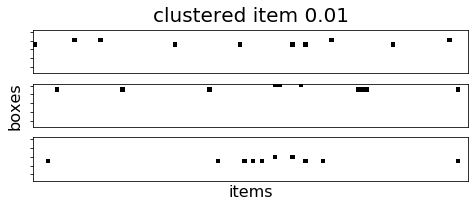

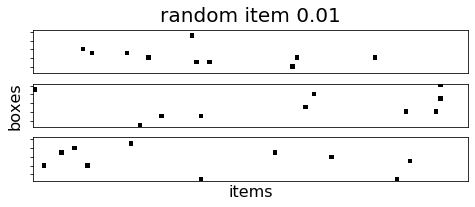

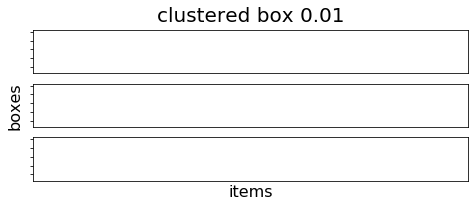

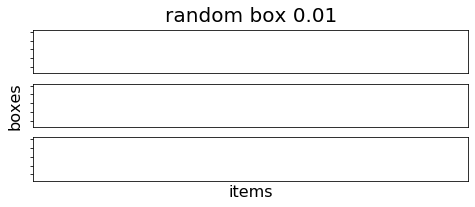

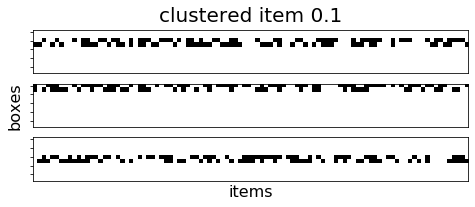

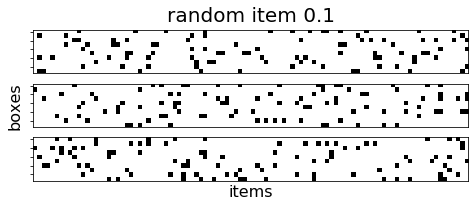

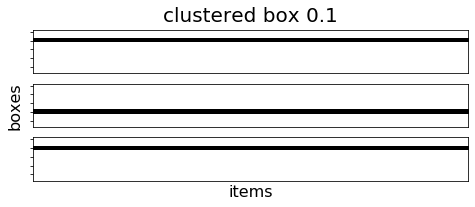

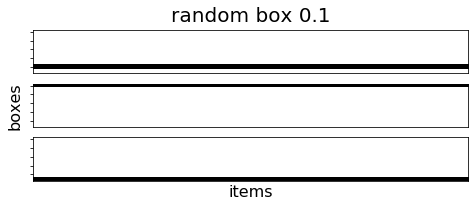

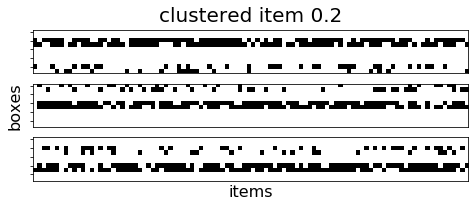

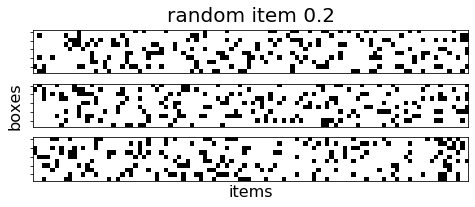

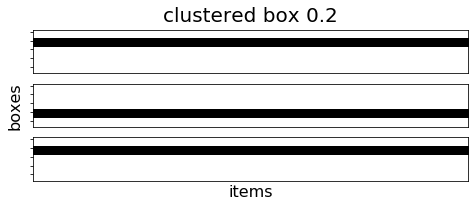

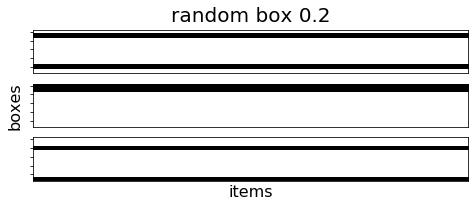

In [15]:
# Plot items for each scenario and check contaminant arrangement and contamination unit
scenarios = contaminate_validation_df_1["consignment name"]

for index, scenario in enumerate(scenarios):
    contaminate_validation_items = np.stack(contaminate_validation_items_unstacked[index])
    items_by_consignment = np.vsplit(contaminate_validation_items, num_consignments_1)
    fig, axs = plt.subplots(len(items_by_consignment), figsize=(7.8,2.8))
    for i in range(len(items_by_consignment)):
        axs[i].matshow(items_by_consignment[i], cmap='Greys')
        axs[i].set_yticklabels([])
        axs[i].tick_params(labeltop=False, top=False, bottom=False)
        if i == 1:
            axs[i].set_ylabel('boxes', fontsize=16)
        if i == 2:
            axs[i].set_xlabel('items', fontsize=16)
        if i == 0:
            axs[i].set_title(scenario, fontsize=20)
        #plt.tight_layout()
        fig.savefig(scenario + "_items.png")

# Sampling validation

### Test: Simulate 1 consignment, using 1 iteration.
Check sample size and indexes inspected using combinations of:
* Number of boxes - 20 or 100 (200 items/box)
* Sampling unit - box or items
* Sample size calculation method - proportion or hypergeometric
* Sample selection method - random, convenience, cluster interval (inspecting 10% of every 3rd box), or cluster random (inspecting 10% of random selected boxes)

In [16]:
# Run sampling validation test
num_consignments = 1
sample_validation = run_scenarios(
    config=basic_config,
    scenario_table=sample_validation_scenarios,
    seed=42,
    num_simulations=1,
    num_consignments=num_consignments,
    detailed=True,
)

Running scenario: sample validation 1
Running scenario: sample validation 2
Running scenario: sample validation 3
Running scenario: sample validation 4
Running scenario: sample validation 5
Running scenario: sample validation 6
Running scenario: sample validation 7
Running scenario: sample validation 8
Running scenario: sample validation 9
Running scenario: sample validation 10
Running scenario: sample validation 11
Running scenario: sample validation 12
Running scenario: sample validation 13
Running scenario: sample validation 14
Running scenario: sample validation 15
Running scenario: sample validation 16
Running scenario: sample validation 17
Running scenario: sample validation 18
Running scenario: sample validation 19
Running scenario: sample validation 20
Running scenario: sample validation 21
Running scenario: sample validation 22
Running scenario: sample validation 23
Running scenario: sample validation 24


In [17]:
# Separate item and inspection details from simulation totals and scenario config.
sample_validation_details = [i[0] for i in sample_validation]
sample_validation_results = [i[1:3] for i in sample_validation]

In [18]:
# Save simulation totals and scenario config to dataframe.
sample_validation_df = save_scenario_result_to_pandas(
    sample_validation_results,
    config_columns=[
        "inspection name",
        "consignment/boxes/min",
        "consignment/boxes/max",
        "consignment/items_per_box/default",
        "inspection/unit",
        "inspection/sample_strategy",
        "inspection/proportion/value",
        "inspection/hypergeometric/detection_level",
        "inspection/selection_strategy",
    ],
    result_columns=[
        "avg_boxes_opened_completion",
        "avg_items_inspected_completion",
    ],
)

In [19]:
# Format dataframe
column_names = ["inspection name", "number of boxes", "items per box", "inspection unit", "sample strategy", "sample parameter", "selection strategy", "items inspected"]
sample_validation_df_pretty = sample_validation_df.iloc[:,[0,1,3,4,5,6,8,10]]
hypergeometric_parameters = sample_validation_df.iloc[[0,1,2,3,8,9,12,13,14,15,20,21],7]

sample_validation_df_pretty.iloc[[0,1,2,3,8,9,12,13,14,15,20,21],5] = hypergeometric_parameters
sample_validation_df_pretty.columns = column_names


/home/vpetras/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [20]:

sample_validation_df_pretty

,inspection name,number of boxes,items per box,inspection unit,sample strategy,sample parameter,selection strategy,items inspected
0,item hypergeometric random,20,100,items,hypergeometric,0.05,random,58.0
1,item hypergeometric convenience,20,100,items,hypergeometric,0.05,convenience,58.0
2,item hypergeometric interval cluster,20,100,items,hypergeometric,0.05,cluster,58.0
3,item hypergeometric random cluster,20,100,items,hypergeometric,0.05,cluster,58.0
4,item proportion random,20,100,items,proportion,0.02,random,40.0
5,item proportion convenience,20,100,items,proportion,0.02,convenience,40.0
6,item proportion interval cluster,20,100,items,proportion,0.02,cluster,40.0
7,item proportion random cluster,20,100,items,proportion,0.02,cluster,40.0
8,box hypergeometric random,20,100,boxes,hypergeometric,0.05,random,1900.0
9,box hypergeometric convenience,20,100,boxes,hypergeometric,0.05,convenience,1900.0


## Check sample sizes
The sample sizes used by the simulation are all as expected.

In [21]:
# Expected sample sizes are calculated as:
# For proportion sampling: sample_size = num_units * proportion
# For hypergeometric: sample_size = (1 - ((1 - confidence_level) ** (1 / (detection_level * population_size)))) * (population_size - (((detection_level * population_size) - 1) / 2))

expected_item_sample_size = np.array([58, 58, 58, 58, 80, 80, 80, 80, 3800, 3800, 400, 400, 59, 59, 59, 59, 400, 400, 400, 400, 9000, 9000, 400, 400])
actual_item_sample_size = sample_validation_df["avg_items_inspected_completion"]
scenarios = sample_validation_df["inspection name"]

sample_size_validatation = pd.DataFrame({"scenarios": scenarios, "expected_item_sample_size": expected_item_sample_size, "actual_item_sample_size": actual_item_sample_size})


In [22]:
sample_size_validatation

,scenarios,expected_item_sample_size,actual_item_sample_size
0,item hypergeometric random,58,58.0
1,item hypergeometric convenience,58,58.0
2,item hypergeometric interval cluster,58,58.0
3,item hypergeometric random cluster,58,58.0
4,item proportion random,80,40.0
5,item proportion convenience,80,40.0
6,item proportion interval cluster,80,40.0
7,item proportion random cluster,80,40.0
8,box hypergeometric random,3800,1900.0
9,box hypergeometric convenience,3800,1900.0


## Check sample selection
The sample selection is as expected.

In [23]:
sample_validation_inspected_indexes = [i[1] for i in sample_validation_details]

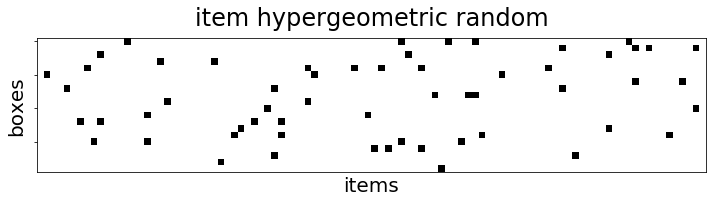

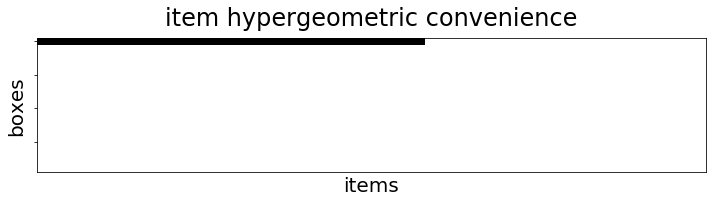

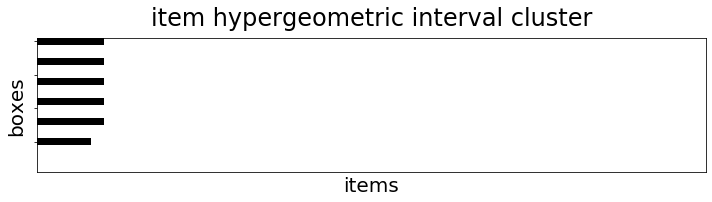

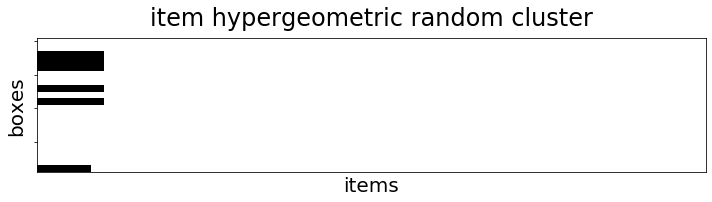

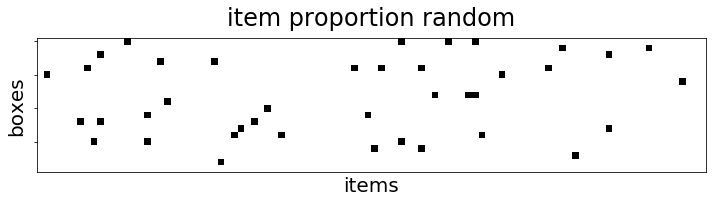

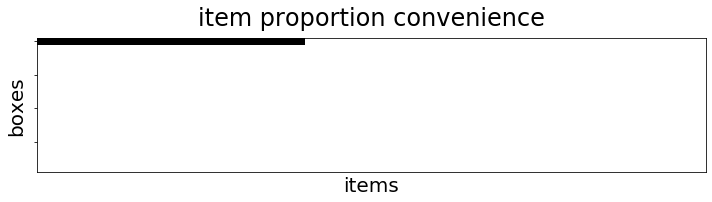

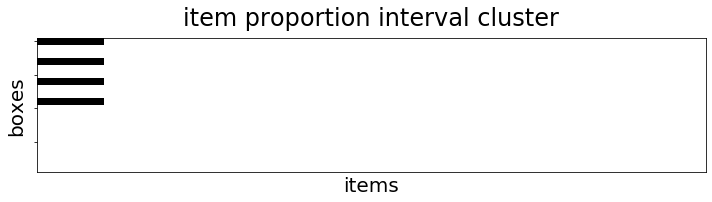

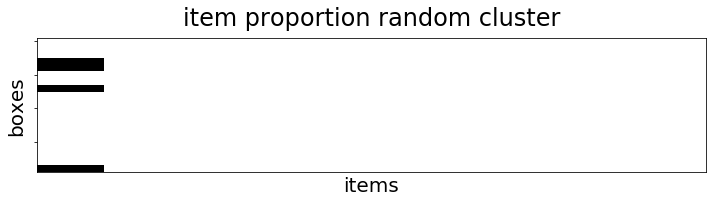

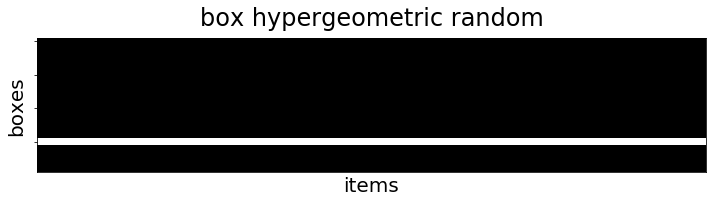

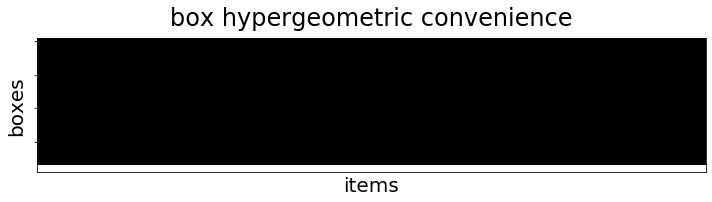

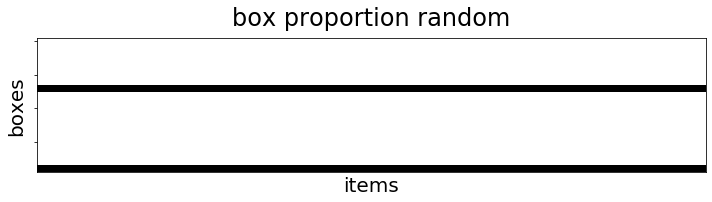

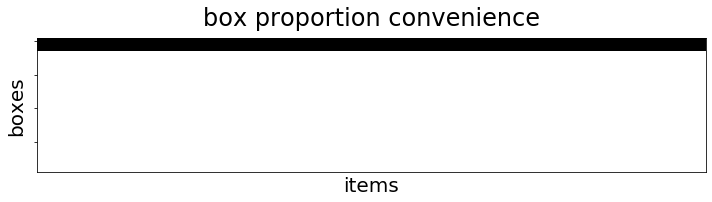

In [24]:
# Use the smaller consignment (20 boxes) sample scenarios (first 12) for plotting the inspected indexes so the consignments are easier to visualize.
sample_scenarios = sample_validation_df[0:12]["inspection name"]
num_items_per_consignment = 2000
num_boxes_per_consignment = 20

for index, scenario in enumerate(sample_scenarios):
    indexes = np.zeros(num_items_per_consignment, dtype=np.int)
    inpsected = sample_validation_inspected_indexes[index][0]
    np.put(indexes, inpsected, 1)
    indexes = np.array_split(indexes, num_boxes_per_consignment)
    fig, axs = plt.subplots(1, figsize=(10,2.8))
    axs.matshow(indexes, cmap='binary', vmin=0, vmax=1)
    axs.set_yticklabels([])
    axs.tick_params(labeltop=False, top=False, bottom=False)
    axs.set_ylabel('boxes', fontsize=20)
    axs.set_xlabel('items', fontsize=20)
    axs.set_title(scenario, fontsize=24)
    plt.tight_layout()
    fig.savefig(scenario + "_inspected.png")


# Inspection outcome validation

### Test: Simulate 2000 consignments with 100 boxes each (200 items/box), using 10 iterations.
Check inspection success rates using combinations of:
* Fixed contamination rates - fixed values of 0.01 and 0.1
* Contamination unit - box or item
* Inspection unit - box or item
* Sample size method - proportion (0.02 and 0.05) and hypergeometric (0.01, 0.05, 0.1 detection levels)
* Contaminant arrangement - random or clustered (box contamination unit: 2 boxes max contaminated units, item infestation unit: 200 items max contaminated units and 300 items max width)

Calculate expected probability of detecting at least one contaminated unit using a binomial distribution for the proportion sampling and a hypergeometric distribution for the hypergeometric sampling.

Probabilities caculated using these online calculators: 

https://stattrek.com/online-calculator/binomial.aspx

https://stattrek.com/online-calculator/hypergeometric.aspx

In [25]:
# Run outcome validation test
num_consignments = 1000
outcome_validation = run_scenarios(
    config=basic_config,
    scenario_table=outcome_validation_scenarios,
    seed=42,
    num_simulations=20,
    num_consignments=num_consignments,
    detailed=False,
)

Running scenario: outcome validation 1
Running scenario: outcome validation 2
Running scenario: outcome validation 3
Running scenario: outcome validation 4
Running scenario: outcome validation 5
Running scenario: outcome validation 6
Running scenario: outcome validation 7
Running scenario: outcome validation 8
Running scenario: outcome validation 9
Running scenario: outcome validation 10
Running scenario: outcome validation 11
Running scenario: outcome validation 12
Running scenario: outcome validation 13
Running scenario: outcome validation 14
Running scenario: outcome validation 15
Running scenario: outcome validation 16
Running scenario: outcome validation 17
Running scenario: outcome validation 18
Running scenario: outcome validation 19
Running scenario: outcome validation 20
Running scenario: outcome validation 21
Running scenario: outcome validation 22
Running scenario: outcome validation 23
Running scenario: outcome validation 24
Running scenario: outcome validation 25
Running s

In [26]:
# Save simulation totals and scenario config to dataframe.
outcome_validation_df = save_scenario_result_to_pandas(
    outcome_validation,
    config_columns=[
        "name",
        "consignment name",
        "inspection name",
        "consignment/boxes/min",
        "consignment/boxes/max",
        "consignment/items_per_box/default",
        "contamination/contamination_unit",
        "contamination/contamination_rate/distribution",
        "contamination/contamination_rate/value",
        "contamination/arrangement",
        "inspection/unit",
        "inspection/sample_strategy",
        "inspection/proportion/value",
        "inspection/hypergeometric/detection_level",
        "inspection/selection_strategy",
    ],
    result_columns=[
        "false_neg",
        "intercepted",
        "total_missed_contaminants",
        "total_intercepted_contaminants",
        "avg_boxes_opened_completion",
        "avg_items_inspected_completion",
    ],
)
outcome_validation_df

,name,consignment name,inspection name,consignment/boxes/min,consignment/boxes/max,consignment/items_per_box/default,contamination/contamination_unit,contamination/contamination_rate/distribution,contamination/contamination_rate/value,contamination/arrangement,...,inspection/sample_strategy,inspection/proportion/value,inspection/hypergeometric/detection_level,inspection/selection_strategy,false_neg,intercepted,total_missed_contaminants,total_intercepted_contaminants,avg_boxes_opened_completion,avg_items_inspected_completion
0,outcome validation 1,random 0.01,items proportion 0.02,100,100,200,items,fixed_value,0.01,random,...,proportion,0.02,,random,17.20,982.80,3440.0,196560.0,98.27825,400.0
1,outcome validation 2,random 0.01,boxes proportion 0.02,100,100,200,boxes,fixed_value,0.01,random,...,proportion,0.02,,random,979.10,20.90,195820.0,4180.0,2.00000,400.0
2,outcome validation 3,random 0.01,items proportion 0.05,100,100,200,items,fixed_value,0.01,random,...,proportion,0.05,,random,0.10,999.90,20.0,199980.0,99.99690,1000.0
3,outcome validation 4,random 0.01,boxes proportion 0.05,100,100,200,boxes,fixed_value,0.01,random,...,proportion,0.05,,random,952.10,47.90,190420.0,9580.0,5.00000,1000.0
4,outcome validation 5,random 0.01,items hypergeometric 0.1,100,100,200,items,fixed_value,0.01,random,...,hypergeometric,,0.1,random,750.45,249.55,150090.0,49910.0,25.30565,29.0
5,outcome validation 6,random 0.01,boxes hypergeometric 0.1,100,100,200,boxes,fixed_value,0.01,random,...,hypergeometric,,0.1,random,751.95,248.05,150390.0,49610.0,25.00000,5000.0
6,outcome validation 7,random 0.01,items hypergeometric 0.05,100,100,200,items,fixed_value,0.01,random,...,hypergeometric,,0.05,random,552.35,447.65,110470.0,89530.0,44.79255,59.0
7,outcome validation 8,random 0.01,boxes hypergeometric 0.05,100,100,200,boxes,fixed_value,0.01,random,...,hypergeometric,,0.05,random,555.20,444.80,111040.0,88960.0,45.00000,9000.0
8,outcome validation 9,random 0.01,items hypergeometric 0.01,100,100,200,items,fixed_value,0.01,random,...,hypergeometric,,0.01,random,48.65,951.35,9730.0,190270.0,95.01090,296.0
9,outcome validation 10,random 0.01,boxes hypergeometric 0.01,100,100,200,boxes,fixed_value,0.01,random,...,hypergeometric,,0.01,random,49.75,950.25,9950.0,190050.0,95.00000,19000.0


In [27]:
# Format dataframe
column_names = ["consignment name", "inspection name", "number of boxes", "items per box", "contamination unit", "contamination distribution", "contamination rate", "contaminant arrangement", "inspection unit", "sample strategy", "sample parameter"]
outcome_validation_df_pretty = outcome_validation_df.iloc[:,[1,2,3,5,6,7,8,9,10,11,12]]

hypergeometric_parameters = outcome_validation_df.iloc[[4,5,6,7,8,9,14,15,16,17,18,19,24,25,26,27,28,29,34,35,36,37,38,39],13]

outcome_validation_df_pretty.iloc[[4,5,6,7,8,9,14,15,16,17,18,19,24,25,26,27,28,29,34,35,36,37,38,39],10] = hypergeometric_parameters
outcome_validation_df_pretty.columns = column_names
outcome_validation_df_pretty

/home/vpetras/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,consignment name,inspection name,number of boxes,items per box,contamination unit,contamination distribution,contamination rate,contaminant arrangement,inspection unit,sample strategy,sample parameter
0,random 0.01,items proportion 0.02,100,200,items,fixed_value,0.01,random,items,proportion,0.02
1,random 0.01,boxes proportion 0.02,100,200,boxes,fixed_value,0.01,random,boxes,proportion,0.02
2,random 0.01,items proportion 0.05,100,200,items,fixed_value,0.01,random,items,proportion,0.05
3,random 0.01,boxes proportion 0.05,100,200,boxes,fixed_value,0.01,random,boxes,proportion,0.05
4,random 0.01,items hypergeometric 0.1,100,200,items,fixed_value,0.01,random,items,hypergeometric,0.1
5,random 0.01,boxes hypergeometric 0.1,100,200,boxes,fixed_value,0.01,random,boxes,hypergeometric,0.1
6,random 0.01,items hypergeometric 0.05,100,200,items,fixed_value,0.01,random,items,hypergeometric,0.05
7,random 0.01,boxes hypergeometric 0.05,100,200,boxes,fixed_value,0.01,random,boxes,hypergeometric,0.05
8,random 0.01,items hypergeometric 0.01,100,200,items,fixed_value,0.01,random,items,hypergeometric,0.01
9,random 0.01,boxes hypergeometric 0.01,100,200,boxes,fixed_value,0.01,random,boxes,hypergeometric,0.01


## Check success rates
The inspection outcomes are very close to expected when using a random contaminant arrangement. 

The last half of the outcome vaildation scenarions use a clustered contaminant arrangement. When the contamination rate is low (0.01), the success rates are still very close to the scenarions with random arrangement. When the contamination rate is increased (0.1), however, actual inspection success rates are much lower than what would be expected if the contaminants were randomly distributed throughout the consignments. This is an expected outcome as well.

In [28]:
# Expected success rates were calculated using binomial probability distributions for proportion sampling and hypergeometric probability distributions for hypergeometric sampling.

expected_success_rate = np.array([0.982049447, 0.0199, 0.999956829, 0.04900995, 0.252981244, 0.25, 0.44779485, 0.45, 0.950071868, 0.95, 0.999999, 0.19, 0.999999, 0.40951, 0.953004939, 0.952113444, 0.99802225, 0.998310334, 1, 1, 0.982049447, 0.0199, 0.999956829, 0.04900995, 0.252981244, 0.25, 0.44779485, 0.45, 0.950071868, 0.95, 0.982049447, 0.0199, 0.999956829, 0.04900995, 0.252981244, 0.25, 0.44779485, 0.45, 0.950071868, 0.95])

contaminated_consignments = outcome_validation_df["false_neg"] + outcome_validation_df["intercepted"]
actual_success_rate = outcome_validation_df["intercepted"] / contaminated_consignments
consignment_name = outcome_validation_df["consignment name"]
inspection_name = outcome_validation_df["inspection name"]

success_rate_validation = pd.DataFrame({"consignment name": consignment_name, "inspection name": inspection_name, "expected_success_rate": expected_success_rate, "actual_success_rate": actual_success_rate, "rate_difference": expected_success_rate - actual_success_rate})

In [29]:
success_rate_validation

,consignment name,inspection name,expected_success_rate,actual_success_rate,rate_difference
0,random 0.01,items proportion 0.02,0.982049,0.98280,-0.000751
1,random 0.01,boxes proportion 0.02,0.019900,0.02090,-0.001000
2,random 0.01,items proportion 0.05,0.999957,0.99990,0.000057
3,random 0.01,boxes proportion 0.05,0.049010,0.04790,0.001110
4,random 0.01,items hypergeometric 0.1,0.252981,0.24955,0.003431
5,random 0.01,boxes hypergeometric 0.1,0.250000,0.24805,0.001950
6,random 0.01,items hypergeometric 0.05,0.447795,0.44765,0.000145
7,random 0.01,boxes hypergeometric 0.05,0.450000,0.44480,0.005200
8,random 0.01,items hypergeometric 0.01,0.950072,0.95135,-0.001278
9,random 0.01,boxes hypergeometric 0.01,0.950000,0.95025,-0.000250
